In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from skimage.filters import gaussian 
import sys

sys.path.append('../')
sys.path.append('../environments/')
import make_simulated_neurons as msn
import data.load_data as load_data
from sac_tracking_env import Environment
import tracking_interface

# Simulate a neuron image

1. Generate simulated swc_file data. This is a list of nodes, each node being a list:
[sample_idx, structure_id, x, y, z, radius, parent_id]

2. Draw the image.

    a. Without artifacts
    
    b. With artifacts

In [8]:
random_contrast=True
# rng = np.random.default_rng(7)
swc_list = msn.make_swc_list((101,101,101),
                        length=20,
                        step_size=3,
                        kappa=20.0,
                        uniform_len=False,
                        random_start=True,
                        rng=None,
                        num_branches=1) # make simulated neuron paths.
if random_contrast:
    color = np.random.rand(3)
    color /= np.linalg.norm(color)
    background = np.random.rand(3)
    background = background / np.linalg.norm(background) * 0.01
swc_data = load_data.draw_neuron_from_swc(swc_list,
                                            width=3,
                                            noise=0.05,
                                            adjust=False,
                                            neuron_color=color,
                                            background_color=background,
                                            random_brightness=True,
                                            dropout=True,
                                            binary=False) # Use simulated paths to draw the image.


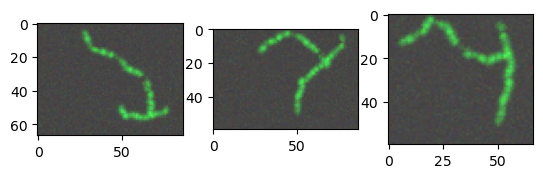

In [9]:
img = swc_data["image"].data.permute(1,2,3,0)

fig, ax = plt.subplots(1,3)
ax[0].imshow(img.amax(0))
ax[1].imshow(img.amax(1))
ax[2].imshow(img.amax(2))    

plt.show()

In [57]:
swc_data['neuron_density'].amax()

tensor(1.)

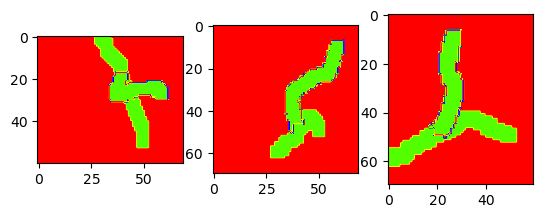

In [66]:
swc_data['section_labels'].shape

img = swc_data["section_labels"][0]

fig, ax = plt.subplots(1,3)
ax[0].imshow(img.amax(0), cmap='prism', interpolation=None)
ax[1].imshow(img.amax(1), cmap='prism', interpolation=None)
ax[2].imshow(img.amax(2), cmap='prism', interpolation=None)    

plt.show()

# Add simulated artifacts

In [44]:
section_labels = swc_data["section_labels"]
neuron_coords = torch.nonzero(section_labels)
density = 0.001
size = int(density * len(neuron_coords))
rand_ints = torch.randint(0, len(neuron_coords), size=(size,))
dropout_points = neuron_coords[rand_ints]

In [45]:
dropout_img = torch.zeros_like(swc_data["image"].data)
dropout_img[:, *dropout_points[:,1:].T] = 1.0

dropout_img = gaussian(dropout_img, sigma=1.5)
dropout_img /= dropout_img.max()


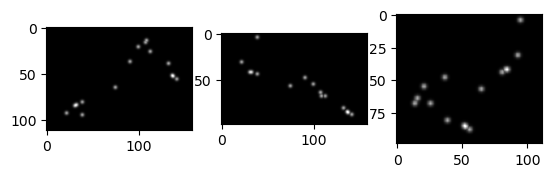

In [46]:
img = dropout_img.transpose(1,2,3,0)

fig, ax = plt.subplots(1,3)
ax[0].imshow(img.max(0))
ax[1].imshow(img.max(1))
ax[2].imshow(img.max(2))    

plt.show()

In [47]:
image_aug = swc_data["image"].data - dropout_img
image_aug = torch.where(image_aug < 0, 0.0, image_aug)

/tmp/ipykernel_5952/2271154198.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  image_aug = swc_data["image"].data - dropout_img


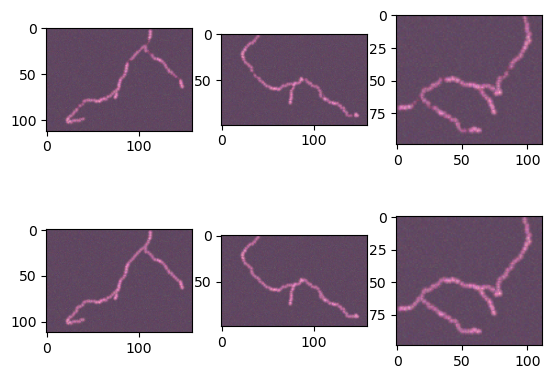

In [48]:
img = image_aug.permute(1,2,3,0)

fig, ax = plt.subplots(2,3)
ax[0,0].imshow(img.amax(0))
ax[0,1].imshow(img.amax(1))
ax[0,2].imshow(img.amax(2))    

img = swc_data["image"].data.permute(1,2,3,0)
ax[1,0].imshow(img.amax(0))
ax[1,1].imshow(img.amax(1))
ax[1,2].imshow(img.amax(2))

plt.show()

In [92]:
f = open("configs/config_simulated_b-2.json")
args = json.load(f)

img_path = args["img_path"]
outdir = args["outdir"]
name = args["name"]
seeds = args["seeds"] if "seeds" in args else None
model = args["model"] if "model" in args else None
n_seeds = args["n_seeds"] if "n_seeds" in args else 1
step_size = args["step_size"] if "step_size" in args else 1.0
step_width = args["step_width"] if "step_width" in args else 1.0
batch_size = args["batchsize"] if "batchsize" in args else 256
gamma = args["gamma"] if "gamma" in args else 0.99
tau = args["tau"] if "tau" in args else 0.005
lr = args["lr"] if "lr" in args else 0.001
alpha = args["alpha"] if "alpha" in args else 1.0
beta = args["beta"] if "beta" in args else 1e-3
friction = args["friction"] if "friction" in args else 1e-4
num_episodes = args["num_episodes"] if "num_episodes" in args else 100
pixelsize = args["pixelsize"] if "pixelsize" in args else [1.0, 1.0, 1.0]
patch_radius = 17

In [93]:
# instantiate environment
env = Environment(img_path,
                  radius=patch_radius,
                  seeds=seeds,
                  step_size=step_size,
                  step_width=step_width,
                  max_len=10000,
                  alpha=alpha,
                  beta=beta,
                  friction=friction,
                  branching=False,
                  classifier=None)

Loading image /Users/brysongray/git_repos/tractography/neuron_trx/training_data/simulated_b-2/img_1


reward: tensor([6.4596])
terminated: False


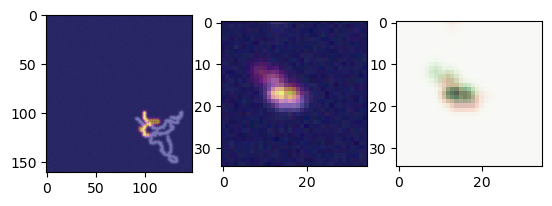

In [96]:
tracking_interface.manual_step(env, step_size=env.step_size)